<a href="https://colab.research.google.com/github/InhyeokYoo/Pytorch-study/blob/master/NLP_FROM_SCRATCH_GENERATING_NAMES_WITH_A_CHARACTER_LEVEL_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
이번 튜토리얼은 밑바닥부터 NLP 시작하기 (NLP from scratch)의 두번째 시간입니다. 첫번째 튜토리얼에선 RNN을 이용하여 이름을 갖고 언어를 구분하는 예제를 진행했었습니다. 이번시간에는 이름을 생성해보도록 하겠습니다.

> 추가 설명 및 부연 설명은 이 글과 같이 citation으로 달겠습니다.   
원본은 https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html 를 참고해주세요.

```
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

저희는 여전히 몇 개의 linear layer로 구성된 직접 만든 RNN을 사용할 것입니다. 이전 튜토리얼과 가장 큰 차이점은 이름에 있는 모든 글자를 input으로 넣고 category를 예측하는 것이 아닌, category를 input으로 매 시점에서의 글자를 예측하는 것입니다. 언어를 구성하기 위해 글자들을 반복하여 예측하는 것을 (이는 단어나 어떤 상위 개념에도 똑같이 적용됩니다) **language modeling**이라 부릅니다.

**Recomended Reading:**

I assume you have at least installed PyTorch, know Python, and understand Tensors:

- https://pytorch.org/ For installation instructions
- Deep Learning with PyTorch: A 60 Minute Blitz to get started with PyTorch in general
- Learning PyTorch with Examples for a wide and deep overview
- PyTorch for Former Torch Users if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

- The Unreasonable Effectiveness of Recurrent Neural Networks shows a bunch of real life examples
- Understanding LSTM Networks is about LSTMs specifically but also informative about RNNs in general
- I also suggest the previous tutorial, NLP From Scratch: Classifying Names with a Character-Level RNN




# Data Preparing
데이터는 [이곳](https://download.pytorch.org/tutorial/data.zip)에서 다운받을 수 있습니다.
> 이전 튜토리얼과 마찬가지로, linux 명령어를 통해 colab의 메모리 혹은 디렉토리에 바로 다운받을 수 있게끔 하겠습니다.



In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-01-26 08:34:47--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.87.81, 13.249.87.32, 13.249.87.127, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.87.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  17.5MB/s    in 0.2s    

2020-01-26 08:34:47 (17.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

이전 튜토리얼에서 작성했던 전처리 함수를 그대로 가져다 쓰겠습니다.

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS (End of Sentence) mark를 달겠습니다.

def find_files(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 lines로 split하겠습니다.
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# category_lines 딕셔너리를 생성하여 category 당 lines의 list를 저장합니다.
category_lines = {}
all_categories = []
for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# category가 0일 경우, exception을 raise합니다.
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Irish', 'Dutch', 'Japanese', 'Greek', 'Korean', 'Polish', 'Vietnamese', 'Arabic', 'Scottish', 'Portuguese', 'Russian', 'German', 'Chinese', 'Spanish', 'French', 'Italian', 'Czech', 'English']
O'Neal


# Creating the Network
이번 네트워크는 [이전 튜토리얼의 RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#Creating-the-Network)을 확장한 것으로, cateogry tensor를 위한 추가 argument가 존재합니다. 이 또한 one-hot vetor로, 다른 tensor와 concatenate됩니다.

여기서 output은 다음 글자의 확률로 해석됩니다. 샘플링할 때, 가장 그럴듯한 output 글자는 다음 input 글자가됩니다.

이번 튜토리얼에서는 두번째 linear layer인 `o2o`(output과 hidden을 합친 후에)가 추가되어 더 많은 기능을 하게됩니다. 또한, overfiting을 방지하는 dropout layer가 있습니다. 여기서는 네트워크의 끝부분에서 이용되어 의도적으로 혼란을 추가하고 sampling variety를 증가시킵니다.
![](https://i.imgur.com/jzVrf7f.png)

> 이번 예제는 Seq2seq와 비슷합니다.

> 밑에는 이전 튜토리얼의 네트워크입니다. 한번 보고 다른점을 한번 확인해보세요.

![](https://i.imgur.com/Z2xbySO.png)

In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # dimension이 헷갈린다면 그림을 확인해보세요.
        self.i2h = nn.Linear(input_size + self.hidden_size + n_categories, self.hidden_size)
        self.i2o = nn.Linear(input_size + self.hidden_size + n_categories, output_size)
        self.o2o = nn.Linear(self.hidden_size + output_size, output_size)
        # Dropout layer를 추가합니다.
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), dim=1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)

        output_combined = torch.cat((hidden, output), dim=1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Training
## Preparing for training
가장 우선적으로, (category, line)으로 이루어진 쌍을 랜덤으로 얻는 helper functions를 만들어보겠습니다.

In [0]:
import random

# list로부터 random하게 요소 뽑아내기
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

# 카테고리로부터 random line과 random category 뽑아내기
def random_training_pair():
    # 카테고리 먼저 랜덤으로 뽑고,
    category = random_choice(all_categories)
    # 뽑은 카테고리에 저장된 이름(line)을 가져옵니다.
    line = random_choice(category_lines[category])
    return category, line

매 timestep(training할 단어의 각 글자)에서, 네트워크의 input은 `(category, current_letter, hidden state)`가 될 것이고, output은 `(next letter, next hidden state)`가 될 것입니다. 따라서 각 training set에 대해, category와 input letter, output/target letters가 필요합니다.

매 timestep에 대해, 현재 글자로부터 다음 글자를 예측해야되기 때문에 글자 쌍은 lines로부터 얻어진 연속적인 글자가 됩니다 - e.g. `ABCD<EOS>`에 대해, ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS")쌍을 만들면 됩니다.

![](https://i.imgur.com/JH58tXY.png)

Category 텐서는 one-hot tensor로, `<1 x n_categories>`의 사이즈를 갖고 있습니다. Training 과정에서 이를 모든 timestep에서 네트워크에 집어넣습니다(feed) - 이는 초기 hidden state나 어떤 다른 전략의 일부분으로 포함될 수 있는 것으로, 선택하기 나름입니다(design choice).

> Design choice는 설계 스타일을 의미하는 것 같습니다.

In [0]:
# 카테고리를 one-hot vector로 바꾸기
def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# input의 첫번째부터 마지막 글자(EOS 제외)의 one-hot matrix
def input_tensor(line):
    '''
    # 원본은 다음과 같이 되어 있으나, dimension을 편리하게 표현해보겠습니다.
    tensor = torch.zeros(len(line), 1, n_letters)
    '''
    # <line_length x batch_size x n_letters>
    line_length = len(line)
    batch_size = 1
    tensor = torch.zeros(line_length, batch_size, n_letters)
    for li in range(line_length):
        letter = line[li]
        # 마지막 차원(n_letters)의 index만 1로 바꾸어주면 one-hot으로 표현 가능합니다.
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Target의 두번째 글자부터 마지막(EOS)까지를 LongTensor로 표현합니다.
def target_tensor(line):
    # 첫번째 글자는 t=1일 때 input으로 주기 때문에 제외합니다.
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))] # list comprehension
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

Training 과정에서 편의를 위해, 랜덤으로 (category, line) 쌍을 가져오는 `random_training_example` 함수를 만들고, 이를 필요한 (category, input, target) 텐서로 변환합니다.

In [0]:
# (random_category, line) 쌍으로부터 category, input, target tensor를 만듭니다.
def random_training_example():
    # random하게 category와 line을 가져옵니다.
    category, line = random_training_pair()
    # category를 <1 x n_categories> tensor로 변환합니다.
    category = category_tensor(category)
    # 이름(line)을 <line_length  x batch_size x n_letters> tensor로 변환(EOS 제외)
    input_line_tensor = input_tensor(line)
    # 이름(line)을 <line_length  x batch_size x n_letters> tensor로 변환(EOS 포함, 첫 글자 제거)
    target_line_tensor = target_tensor(line)
    return category, input_line_tensor, target_line_tensor

## Traning the Network
오직 마지막 output만이 사용되는 classification 문제와는 반대로, 모든 스텝에서 예측하여 모든 스텝에서의 loss를 계산합니다.

Autograd의 마술덕분에 우리는 매 순간에서의 losses를 단순히 더하고 마지막에 backward함수만 더하면 됩니다.

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    '''
    # 원본은 다음과 같이 gradient를 update합니다.
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    '''
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

Training 과정에서 소요되는 시간을 기록하기 위해 `time_since(timestamp)`함수를 만들겠습니다. 이 함수는 사람이 읽을 수 있는 string을 반환합니다:

In [0]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    # f string을 사용하겠습니다
    return f'{m}m {s}s'

Training은 평상시와 같이 진행합니다 - train을 몇 번 호출하고, 몇 분 기다린 후, 매 `print_every`번째 마다 현재 시간과 loss를 출력하고, `plot_every`번째마다 평균 loss를 `all_losses`에 저장하여 추후에 plotting합니다.

In [0]:
rnn = RNN(n_letters, 128, n_letters)

# 위에서 직접 update를 하는 것이 아닌, optimizer로 접근했기 때문에 여기서 optimizer를 만들어줍니다.
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss

    if iter % print_every == 0:
        print(f'{time_since(start)} ({iter} {iter / n_iters * 100}%) {loss:.4f}')

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 13.217996597290039s (5000 5.0%) 2.4005
0m 26.537834644317627s (10000 10.0%) 3.1587
0m 39.96205163002014s (15000 15.0%) 2.7366
0m 53.25227069854736s (20000 20.0%) 2.1939
1m 6.545685768127441s (25000 25.0%) 2.4484
1m 19.706288814544678s (30000 30.0%) 2.9784
1m 33.117918491363525s (35000 35.0%) 2.9835
1m 46.60876774787903s (40000 40.0%) 3.1673
1m 59.79396867752075s (45000 45.0%) 2.0760
2m 13.181854248046875s (50000 50.0%) 2.9127
2m 26.867607831954956s (55000 55.00000000000001%) 1.1377
2m 40.70514440536499s (60000 60.0%) 3.0959
2m 54.16928696632385s (65000 65.0%) 2.0902
3m 7.504065275192261s (70000 70.0%) 1.8151
3m 20.8232159614563s (75000 75.0%) 2.5841
3m 34.19641709327698s (80000 80.0%) 2.0511
3m 47.752302169799805s (85000 85.0%) 1.6212
4m 1.099242925643921s (90000 90.0%) 1.8623
4m 14.33629035949707s (95000 95.0%) 2.2072
4m 27.73836398124695s (100000 100.0%) 1.7043


# Plotting the Losses

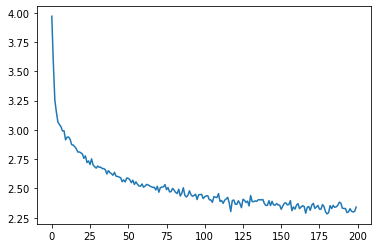

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Sampling the Network
샘플링하기 위해서는 네트워크에 글자를 주고 다음 글자가 뭔지 예측하고, 이를 다시 넣어 그 다음 글자를 예측하고, 이를 EOS 토큰을 얻을 때까지 반복한다.
- input category, 이름의 첫 글자, 비어있는 hidden state의 tensor를 생성한다
- starting letter를 통해 `output_name`이라는 string을 생성한다
- 최고 output 길이에 도달할 때까지
 - 현재 글자를 network에 입력한다
 - 최고 확률을 갖는 다음 글자, output과 hidden state를 얻는다
 - 글자가 EOS라면 종료한다
 - 일반적인 글자라면, `output_name`에 글자를 추가하고 계속한다
- 최종 이름을 반환한다

**Note**  
시작 글자를 주는 대신, 훈련과정에서 "Start of String" 토큰을 주어 네트워크가 맨 처음 글자를 고르는 방법도 있습니다.

> 일반적으로는 <BOS> 토큰이라고 부릅니다.

In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():
        # input category, 이름의 첫 글자, 비어있는 hidden state의 tensor를 생성합니다.

        # CamelCase를 Pythonic하게 바꾸는 과정에서 variable과 function 이름이 중복되었습니다.
        # 따라서 category_tensor를 category라는 이름으로 저장하겠습니다.
        # 원래라면 parameter와 동명의 이름을 갖기 때문에 좋은 코딩방법은 아닙니다.
        category = category_tensor(category)
        input = input_tensor(start_letter)
        hidden = rnn.init_hidden()

        # starting letter를 통해 output_name이라는 string을 생성한다
        output_name = start_letter  # Immutable

        for i in range(max_length):
            # 현재 글자를 network에 입력한다
            output, hidden = rnn(category, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]

            # 최고 output 길이에 도달할 때까지
            if topi == n_letters - 1:
                break
            else:
                # 일반적인 글자라면, output_name에 글자를 추가하고 계속한다
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)
        
        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters="ABC"):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

samples("Korean", "KOR")

Rovaki
Uanishin
Sharivavivin
Gerre
Ererer
Ronger
Salla
Perra
Allara
Can
Han
Iun
Kon
Oon
Ron


# Exercise
- 다른 데이터 셋을 통해 category -> line을 예측해보십시오
 - 픽션 -> 캐릭터 이름
 - 품사 -> 단어
 - 나라 -> 도시  
- "Start of Sentence" 토큰을 사용하여 시작 글자를 선택하지 않고 시도해봅니다 - 더 크거나 더 나은 네트워크를 이용해봅시다
 - nn.LSTM, nn.GRU 네트워크
 - 이러한 RNN 여러개를 묶어 높은 단계의 네트워크로 사용하기